# Adaptation of Market Crashes Paper

We use techniques built in previous papers to generate a series of volume bars (create a new candle stick for every x amount of btc traded). These bars are then used as the input for computing a series of L1 norms (the close values are embedded in 4d space, sliding window generates point clouds, l1 norm of said point cloud).

Then, the l1 norm time series is binned and made a uniform time series by averaging the norms in each hourly bin.

This time series is plotted against the l1 norm time series of just hourly closes, the price of btc over time, and bollinger bands.

The results are interesting, and show that the orderflow norm reacts quicker to big moves as a result of the volume information being included. 

In [78]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta, date

from gtda.time_series import SingleTakensEmbedding
from gtda.time_series import SlidingWindow
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import Amplitude


from sklearn import set_config
set_config(display='diagram')  # For HTML representations of pipelines

from sklearn.cluster import KMeans


import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import json

from binance import Client, ThreadedWebsocketManager, ThreadedDepthCacheManager
import config as c 

key, secret = c.apis[1][0], c.apis[1][1]
client = Client(key, secret)

from ta.volatility import BollingerBands

# config has variable 'apis = [[# YOUR API KEY],[#YOUR API SECRET]]

In [2]:
def get_date(timestamp):
    obj = datetime.fromtimestamp(timestamp/1000.0)
    return "%s_%s_%s %s:%s" % (obj.month, obj.day, obj.year, obj.hour, obj.minute)

def get_timestamp(date):
    dt_obj = datetime.strptime(date, '%m_%d_%Y %H:%M')
    return int(dt_obj.timestamp() * 1000)

In [3]:
# Code for creating volume bars

def seperate_by_volume(trades, frequency=200):

    times = trades[:,0]
    prices = trades[:,1]
    volumes = trades[:,2]
    ans = np.zeros(shape=(len(prices), 6))
    candle_counter = 0
    vol = 0
    lasti = 0
    
    for i in range(len(prices)):
        vol += volumes[i]
        if vol >= frequency:
            ans[candle_counter][0] = times[i]              # time
            ans[candle_counter][1] = prices[lasti]                     # open
            ans[candle_counter][2] = np.max(prices[lasti:i+1])         # high
            ans[candle_counter][3] = np.min(prices[lasti:i+1])         # low
            ans[candle_counter][4] = prices[i]                         # close
            ans[candle_counter][5] = np.sum(volumes[lasti:i+1])        # volume
            candle_counter += 1
            lasti = i+1
            vol = 0
    
    return ans[:candle_counter]

def gen_bars(bars_arr):
    for i in range(1,len(bars_arr)-1):
        if bars_arr[i-1][0] == bars_arr[i][0]:
            bars_arr[i][0] = (bars_arr[i-1][0] + bars_arr[i+1][0])/2
    if bars_arr[len(bars_arr)-1][0] == bars_arr[len(bars_arr)-2][0]:
        bars_arr[len(bars_arr)-1][0] += bars_arr[len(bars_arr)-1][0] - int(bars_arr[len(bars_arr)-1][0])
        
    return pd.DataFrame([i[1:] for i in bars_arr], columns = ["Open", "High", "Low", "Close", "Volume"], index=pd.to_datetime([i[0] for i in bars_arr], unit='ms')).sort_index()

In [4]:
# gather orderflow data stored locally, generate volume bars and organize into dataframe

orderflow = []
dates = [1577854800000 + i*3600000*60 + 100000 for i in range(1, 60)]
date = dates[0]
for date in dates[:18]:
    with open("orderflow_data/con_"+get_date(date).split(" ", 1)[0], "r") as f:
        orderflow.extend(json.loads(f.read()))

trades = np.array([[float(i["T"]), float(i["p"]), float(i["q"])] for i in orderflow])

bars_arr = seperate_by_volume(trades)

data_df = gen_bars(bars_arr)

In [56]:
# tda pipeline on orderflow bars

x, dates = data_df["Close"].to_numpy(), data_df.index

STE = SingleTakensEmbedding(parameters_type="fixed", dimension=4)
x_STE, dates_ste = STE.fit_transform_resample(X = x, y = dates)

SW = SlidingWindow(size=50)
x_sw, y_sw  = SW.fit_transform_resample(x_STE, dates_ste)

VR = VietorisRipsPersistence(homology_dimensions=[0,1], n_jobs=6)
x_vr = VR.fit_transform(X = x_sw)


Ampl = Amplitude(metric="landscape", metric_params={"p":1})
norm = Ampl.fit_transform(X=x_vr, y=y_sw)

In [65]:
# binning and making ordeflow norms uniform

period = "1h"
start = pd.to_datetime(y_sw[1]).replace(microsecond=0, 
                                        second=0, 
                                        minute=0, 
                                        hour = pd.to_datetime(y_sw[1]).hour,
                                        day = pd.to_datetime(y_sw[1]).day)
end = pd.to_datetime(y_sw[-1]).replace(microsecond=0, second=0, minute=0, hour = pd.to_datetime(y_sw[-1]).hour)
idx = pd.date_range(start=start, end=end, freq = period)



norm_df = pd.DataFrame(
    {
        "Orderflow Norm": norm[:,1][1:],
    },
    index = y_sw[1:]
)
# reindex calced_df to be evenly spaces
norm_df = norm_df.to_period(freq = period).groupby(norm_df.to_period(freq = period).index).mean().to_timestamp().reindex(idx, fill_value=0)

In [68]:
# download data from binance 

columns = ["Open Time", "Open", "High", "Low", "Close", "Volume",
            "Close Time", "Quote Asset Volume", "Number of Trades",
            "Taker Buy Base Volume", "Taker Buy Quote Asset Volume",
            "Ignore"]
period = "1h"

start = pd.to_datetime(y_sw[1]).replace(microsecond=0, 
                                        second=0, 
                                        minute=0, 
                                        hour = pd.to_datetime(y_sw[1]).hour - 4,
                                        day = pd.to_datetime(y_sw[1]).day - 2)
end = pd.to_datetime(y_sw[-1]).replace(microsecond=0, second=0, minute=0, hour = pd.to_datetime(y_sw[-1]).hour)
idx = pd.date_range(start=start, end=end, freq = period)




klines = client.get_historical_klines("BTCUSDT", period, str(start.timestamp() * 1000-3600000), str(end.timestamp() * 1000))
klines = [[float(i) for i in line] for line in klines ]
k_df = pd.DataFrame(klines, columns = columns, index = idx)

In [69]:
# tda on regular binance closes, which is was was done in previous paper

x, dates = k_df["Close"].to_numpy(), k_df.index

STE = SingleTakensEmbedding(parameters_type="fixed", dimension=4)
x_STE, dates_ste = STE.fit_transform_resample(X = x, y = dates)

SW = SlidingWindow(size=50)
x_sw, y_sw  = SW.fit_transform_resample(x_STE, dates_ste)


VR = VietorisRipsPersistence(homology_dimensions=[0,1], n_jobs=6)
x_vr = VR.fit_transform(X = x_sw)


Ampl = Amplitude(metric="landscape", metric_params={"p":1})
norm_orgi = Ampl.fit_transform(X=x_vr, y=y_sw)

norm_df["Previous Norm"] = norm_orgi[:,1]

In [77]:
# Add Bollinger Bands features

indicator_bb = BollingerBands(close=k_df["Close"], window=20, window_dev=2)

k_df['bb_bbm'] = indicator_bb.bollinger_mavg()
k_df['bb_bbh'] = indicator_bb.bollinger_hband()
k_df['bb_bbl'] = indicator_bb.bollinger_lband()


# add bollinger lines to plot
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Candlestick(x=idx,
                open=k_df['Open'], high=k_df['High'],
                low=k_df['Low'], close=k_df['Close']) )

fig.add_trace(go.Scatter(x=idx, y=k_df['bb_bbm']))
fig.add_trace(go.Scatter(x=idx, y=k_df['bb_bbh']))
fig.add_trace(go.Scatter(x=idx, y=k_df['bb_bbl']))



for i, col in enumerate(norm_df.keys(), start=1):
    if "Norm" in col:
        normed_norm = norm_df[col].values/max(norm_df[col].values)
        # normed_norm = [8000 if i > .2 else 7000 for i in normed_norm ]
        fig.add_trace(go.Scatter(x=norm_df[col].index, y=normed_norm, name=col), secondary_y=True)
    else:
        fig.add_trace(go.Scatter(x=norm_df[col].index, y=norm_df[col].values, name=col))

fig.update_layout(
    # width=1050,
    hovermode="x",
    xaxis_rangeslider_visible=False
)


fig.show()



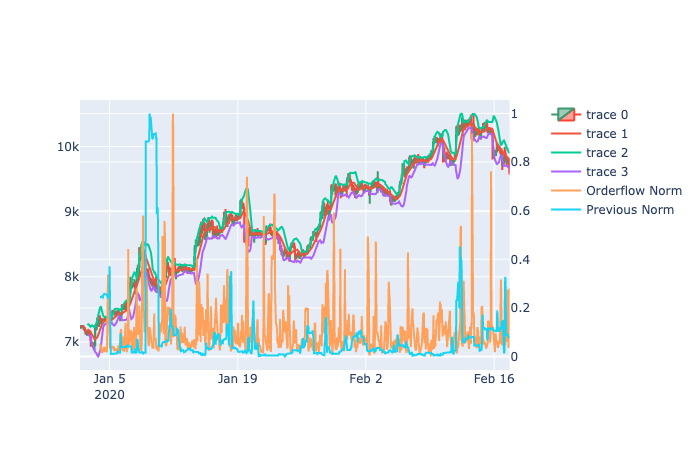

In [79]:
from IPython import display
display.Image("../images/orderflow_tda.png")

Results show that orderflow norm reacts slightly quicker than previous norm, and reacts more closely to bollinger bands and ergo tradional volatility indicators